In [1]:
import numpy as np
import tensorflow as tf
import lightgbm as lgb

from src.loaders.data_loader import load_train_data, load_test_data

np.random.seed(42)

In [2]:
raw_df = load_train_data()

In [3]:
raw_df.head(5)

,Day,Hour,Minute,DHI,DNI,WS,RH,T,TARGET
0,0,0,0,0,0,1.5,69.08,-12,0.0
1,0,0,30,0,0,1.5,69.06,-12,0.0
2,0,1,0,0,0,1.6,71.78,-12,0.0
3,0,1,30,0,0,1.6,71.75,-12,0.0
4,0,2,0,0,0,1.6,75.20,-12,0.0


In [4]:
raw_df.describe()

,Day,Hour,Minute,DHI,DNI,WS,RH,T,TARGET
count,52560.000000,52560.000000,52560.000000,52560.000000,52560.000000,52560.000000,52560.000000,52560.000000,52560.000000
mean,547.000000,11.500000,15.000000,64.344121,234.792371,2.456033,56.793102,9.279928,17.790630
std,316.102148,6.922252,15.000143,103.897125,349.684583,1.426874,22.052875,10.179741,25.759955
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.590000,-19.000000,0.000000
25%,273.000000,5.750000,0.000000,0.000000,0.000000,1.400000,39.697500,1.000000,0.000000
50%,547.000000,11.500000,15.000000,0.000000,0.000000,2.200000,57.600000,9.000000,0.000000
75%,821.000000,17.250000,30.000000,87.000000,469.000000,3.200000,72.770000,17.000000,32.089890
max,1094.000000,23.000000,30.000000,528.000000,1059.000000,12.000000,100.000000,35.000000,99.913939


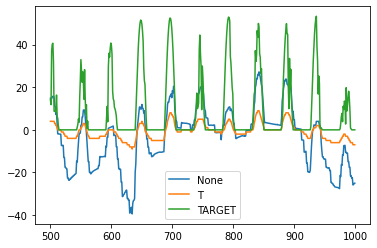

In [5]:
import matplotlib.pyplot as plt
_mean = raw_df["T"].rolling(336).mean()
_std = raw_df["T"].rolling(336).std()
# (raw_df["RH"] )[0:450].plot()
scaled_rh = (raw_df["RH"]) / 100
rh_std = scaled_rh  * (raw_df["T"] - _mean) / _std * 20
rh_std[500:1000].plot()
raw_df["T"][500:1000].plot()
raw_df["TARGET"][500:1000].plot()
plt.legend()

In [6]:
from src.preprocessors.add_columns import add_sin_cos_day, add_sin_cos_hour, add_ghi

def feature_engineering(df):
#     df = add_sin_cos_day(df)
#     df = add_sin_cos_hour(df)
    df = add_ghi(df)

    df["TARGET_ROLLING_MEAN_3"] = df["TARGET"].rolling(4).mean()
    df["TARGET_ROLLING_MEAN_5"] = df["TARGET"].rolling(6).mean()
    df["TARGET_ROLLING_MEAN_11"] = df["TARGET"].rolling(12).mean()
    df["TARGET_ROLLING_MEAN_23"] = df["TARGET"].rolling(24).mean()
    df["TARGET_ROLLING_MEAN_47"] = df["TARGET"].rolling(48).mean()
    
    df["DHI_ROLLING_MEAN_3"] = df["DHI"].rolling(4).mean()
    df["DHI_ROLLING_MEAN_5"] = df["DHI"].rolling(6).mean()
    df["DHI_ROLLING_MEAN_11"] = df["DHI"].rolling(12).mean()
    df["DHI_ROLLING_MEAN_23"] = df["DHI"].rolling(24).mean()
    df["DHI_ROLLING_MEAN_47"] = df["DHI"].rolling(48).mean()
    
    df["DNI_ROLLING_MEAN_3"] = df["DNI"].rolling(4).mean()
    df["DNI_ROLLING_MEAN_5"] = df["DNI"].rolling(6).mean()
    df["DNI_ROLLING_MEAN_11"] = df["DNI"].rolling(12).mean()
    df["DNI_ROLLING_MEAN_23"] = df["DNI"].rolling(24).mean()
    df["DNI_ROLLING_MEAN_47"] = df["DNI"].rolling(48).mean()
    
    df["GHI_ROLLING_MEAN_3"] = df["GHI"].rolling(4).mean()
    df["GHI_ROLLING_MEAN_5"] = df["GHI"].rolling(6).mean()
    df["GHI_ROLLING_MEAN_11"] = df["GHI"].rolling(12).mean()
    df["GHI_ROLLING_MEAN_23"] = df["GHI"].rolling(24).mean()
    df["GHI_ROLLING_MEAN_47"] = df["GHI"].rolling(48).mean()
    
#     scaled_rh = (df["RH"]) / 100
#     _mean = df["T"].rolling(96).mean()
#     _std = df["T"].rolling(96).std()
#     df["SCALED_RH"] = scaled_rh * (df["T"] - _mean) / _std
#     df["RH_CROSS_T"] = df["RH"] * df["T"]
    
    df.drop(["Day", "Hour", "Minute", "WS", "RH", "T", "DNI", "DHI"], axis=1, inplace=True)
    
    return df

In [7]:
preprocessed_df = feature_engineering(raw_df)
preprocessed_df.dropna(inplace=True)
preprocessed_df.head(10)

,TARGET,GHI,TARGET_ROLLING_MEAN_3,TARGET_ROLLING_MEAN_5,TARGET_ROLLING_MEAN_11,TARGET_ROLLING_MEAN_23,TARGET_ROLLING_MEAN_47,DHI_ROLLING_MEAN_3,DHI_ROLLING_MEAN_5,DHI_ROLLING_MEAN_11,...,DNI_ROLLING_MEAN_3,DNI_ROLLING_MEAN_5,DNI_ROLLING_MEAN_11,DNI_ROLLING_MEAN_23,DNI_ROLLING_MEAN_47,GHI_ROLLING_MEAN_3,GHI_ROLLING_MEAN_5,GHI_ROLLING_MEAN_11,GHI_ROLLING_MEAN_23,GHI_ROLLING_MEAN_47
47,0.0,0.0,0.0,0.0,0.0,5.662394,6.520751,0.0,0.0,0.0,...,0.0,0.0,0.0,21.083333,78.708333,0.0,5.092223e-14,0.0,71.509959,106.145284
48,0.0,0.0,0.0,0.0,0.0,4.852930,6.520751,0.0,0.0,0.0,...,0.0,0.0,0.0,19.541667,78.708333,0.0,5.092223e-14,0.0,62.051626,106.145284
49,0.0,0.0,0.0,0.0,0.0,3.781464,6.520751,0.0,0.0,0.0,...,0.0,0.0,0.0,14.000000,78.708333,0.0,5.092223e-14,0.0,47.634959,106.145284
50,0.0,0.0,0.0,0.0,0.0,2.756913,6.520751,0.0,0.0,0.0,...,0.0,0.0,0.0,9.250000,78.708333,0.0,5.092223e-14,0.0,34.255145,106.145284
51,0.0,0.0,0.0,0.0,0.0,1.869230,6.520751,0.0,0.0,0.0,...,0.0,0.0,0.0,5.041667,78.708333,0.0,5.092223e-14,0.0,22.481874,106.145284
52,0.0,0.0,0.0,0.0,0.0,1.380417,6.520751,0.0,0.0,0.0,...,0.0,0.0,0.0,4.958333,78.708333,0.0,5.092223e-14,0.0,17.243038,106.145284
53,0.0,0.0,0.0,0.0,0.0,0.766469,6.520751,0.0,0.0,0.0,...,0.0,0.0,0.0,2.083333,78.708333,0.0,5.092223e-14,0.0,9.128215,106.145284
54,0.0,0.0,0.0,0.0,0.0,0.524015,6.520751,0.0,0.0,0.0,...,0.0,0.0,0.0,2.083333,78.708333,0.0,5.092223e-14,0.0,6.544882,106.145284
55,0.0,0.0,0.0,0.0,0.0,0.207261,6.520751,0.0,0.0,0.0,...,0.0,0.0,0.0,0.458333,78.708333,0.0,5.092223e-14,0.0,2.354167,106.145284
56,0.0,0.0,0.0,0.0,0.0,0.039106,6.520751,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,78.708333,0.0,5.092223e-14,0.0,0.416667,106.145284


In [8]:
raw_df.shape

(52513, 22)

In [9]:
target_index = [i for i, s in enumerate(preprocessed_df.columns) if s == "TARGET"][0]

In [10]:
preprocessed_df.head(10)

,TARGET,GHI,TARGET_ROLLING_MEAN_3,TARGET_ROLLING_MEAN_5,TARGET_ROLLING_MEAN_11,TARGET_ROLLING_MEAN_23,TARGET_ROLLING_MEAN_47,DHI_ROLLING_MEAN_3,DHI_ROLLING_MEAN_5,DHI_ROLLING_MEAN_11,...,DNI_ROLLING_MEAN_3,DNI_ROLLING_MEAN_5,DNI_ROLLING_MEAN_11,DNI_ROLLING_MEAN_23,DNI_ROLLING_MEAN_47,GHI_ROLLING_MEAN_3,GHI_ROLLING_MEAN_5,GHI_ROLLING_MEAN_11,GHI_ROLLING_MEAN_23,GHI_ROLLING_MEAN_47
47,0.0,0.0,0.0,0.0,0.0,5.662394,6.520751,0.0,0.0,0.0,...,0.0,0.0,0.0,21.083333,78.708333,0.0,5.092223e-14,0.0,71.509959,106.145284
48,0.0,0.0,0.0,0.0,0.0,4.852930,6.520751,0.0,0.0,0.0,...,0.0,0.0,0.0,19.541667,78.708333,0.0,5.092223e-14,0.0,62.051626,106.145284
49,0.0,0.0,0.0,0.0,0.0,3.781464,6.520751,0.0,0.0,0.0,...,0.0,0.0,0.0,14.000000,78.708333,0.0,5.092223e-14,0.0,47.634959,106.145284
50,0.0,0.0,0.0,0.0,0.0,2.756913,6.520751,0.0,0.0,0.0,...,0.0,0.0,0.0,9.250000,78.708333,0.0,5.092223e-14,0.0,34.255145,106.145284
51,0.0,0.0,0.0,0.0,0.0,1.869230,6.520751,0.0,0.0,0.0,...,0.0,0.0,0.0,5.041667,78.708333,0.0,5.092223e-14,0.0,22.481874,106.145284
52,0.0,0.0,0.0,0.0,0.0,1.380417,6.520751,0.0,0.0,0.0,...,0.0,0.0,0.0,4.958333,78.708333,0.0,5.092223e-14,0.0,17.243038,106.145284
53,0.0,0.0,0.0,0.0,0.0,0.766469,6.520751,0.0,0.0,0.0,...,0.0,0.0,0.0,2.083333,78.708333,0.0,5.092223e-14,0.0,9.128215,106.145284
54,0.0,0.0,0.0,0.0,0.0,0.524015,6.520751,0.0,0.0,0.0,...,0.0,0.0,0.0,2.083333,78.708333,0.0,5.092223e-14,0.0,6.544882,106.145284
55,0.0,0.0,0.0,0.0,0.0,0.207261,6.520751,0.0,0.0,0.0,...,0.0,0.0,0.0,0.458333,78.708333,0.0,5.092223e-14,0.0,2.354167,106.145284
56,0.0,0.0,0.0,0.0,0.0,0.039106,6.520751,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,78.708333,0.0,5.092223e-14,0.0,0.416667,106.145284


In [11]:
one_day = 48
x_day = 5
one_set = one_day * (x_day + 2)


set_df = []
target_df = []
target_df = []
for i in range(0, len(preprocessed_df) - one_set + 1, 48):
    tmp = preprocessed_df[i:i + one_set].values
    
    tmp = tmp.reshape((x_day + 2), 48, -1)
    tmp = tmp.transpose(1, 0, 2)
    x = tmp[:, :x_day, ]
    y = tmp[:, x_day:, ]
    
    for j in range(48):
        set_df.append(x[j, :, :])
        target_df.append(y[j, :, :])
           
set_df = np.array(set_df)
target_df = np.array(target_df)
set_df.shape, target_df.shape

((52224, 5, 22), (52224, 2, 22))

In [12]:
target_df[0:48, 0, target_index]

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.75082428,  1.59548405,  4.88025053,
        3.75399761,  5.44323672,  8.44630898, 12.29407195, 16.8924323 ,
       20.92761669, 26.0891365 , 24.11810933, 24.11810933, 26.83960805,
       33.03372679, 26.18298232, 18.67552238, 10.79250591,  3.47240963,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ])

In [13]:
all_df = np.concatenate((set_df, target_df), axis=1)
# np.random.shuffle(all_df)

train, valid, test = all_df[:int(all_df.shape[0] * 0.6)], all_df[int(all_df.shape[0]* 0.6): int(all_df.shape[0] * 0.9)], all_df[int(all_df.shape[0] * 0.9):int(all_df.shape[0] * 1.0)]
train, valid, test = all_df[:int(all_df.shape[0] * 0.6)], all_df[int(all_df.shape[0]* 0.7): int(all_df.shape[0] * 1.0)], all_df[int(all_df.shape[0] * 0.6):int(all_df.shape[0] * 0.7)]
train, valid, test = (
    all_df[int(all_df.shape[0]* 0.4): int(all_df.shape[0] * 1.0)], 
    all_df[int(all_df.shape[0]* 0.1): int(all_df.shape[0] * 0.3)], 
    all_df[int(all_df.shape[0] * 0.9):int(all_df.shape[0] * 1.0)]
)
train, valid, test = all_df[:int(all_df.shape[0] * 0.6)], all_df[int(all_df.shape[0]* 0.7): int(all_df.shape[0] * 1.0)], all_df[int(all_df.shape[0] * 0.6):int(all_df.shape[0] * 0.7)]

train.shape, valid.shape, test.shape

((31334, 7, 22), (15668, 7, 22), (5222, 7, 22))

In [14]:
target_index = [i for i, s in enumerate(preprocessed_df.columns) if s == "TARGET"][0]

In [15]:
train.shape

(31334, 7, 22)

In [16]:
x_shape = x_day * train.shape[2]

train_x, train_y_1, train_y_2 = train[:, :x_day, :].reshape(-1, x_shape), train[:, x_day:x_day + 1, target_index].reshape(-1), train[:, x_day + 1:, target_index].reshape(-1)
valid_x, valid_y_1, valid_y_2 = valid[:, :x_day, :].reshape(-1, x_shape), valid[:, x_day:x_day + 1, target_index].reshape(-1), valid[:, x_day + 1:, target_index].reshape(-1)
test_x, test_y_1, test_y_2 = test[:, :x_day, :].reshape(-1, x_shape), test[:, x_day:x_day + 1, target_index].reshape(-1), test[:, x_day + 1:, target_index].reshape(-1)


In [17]:
train_x.shape, train_y_1.shape, train_y_2.shape, valid_x.shape, valid_y_1.shape, test_x.shape, test_y_1.shape

((31334, 110),
 (31334,),
 (31334,),
 (15668, 110),
 (15668,),
 (5222, 110),
 (5222,))

In [18]:
columns = [f"{day}_{column}" for day in range(x_day) for column in preprocessed_df.columns]

In [19]:
train_1_dataset = lgb.Dataset(train_x, label=train_y_1, feature_name=columns)
train_2_dataset = lgb.Dataset(train_x, label=train_y_2, feature_name=columns)
valid_1_dataset = lgb.Dataset(valid_x, label=valid_y_1, feature_name=columns)
valid_2_dataset = lgb.Dataset(valid_x, label=valid_y_2, feature_name=columns)
test_1_dataset = lgb.Dataset(test_x, label=test_y_1, feature_name=columns)
test_2_dataset = lgb.Dataset(test_x, label=test_y_2, feature_name=columns)

In [20]:
columns

['0_TARGET',
 '0_GHI',
 '0_TARGET_ROLLING_MEAN_3',
 '0_TARGET_ROLLING_MEAN_5',
 '0_TARGET_ROLLING_MEAN_11',
 '0_TARGET_ROLLING_MEAN_23',
 '0_TARGET_ROLLING_MEAN_47',
 '0_DHI_ROLLING_MEAN_3',
 '0_DHI_ROLLING_MEAN_5',
 '0_DHI_ROLLING_MEAN_11',
 '0_DHI_ROLLING_MEAN_23',
 '0_DHI_ROLLING_MEAN_47',
 '0_DNI_ROLLING_MEAN_3',
 '0_DNI_ROLLING_MEAN_5',
 '0_DNI_ROLLING_MEAN_11',
 '0_DNI_ROLLING_MEAN_23',
 '0_DNI_ROLLING_MEAN_47',
 '0_GHI_ROLLING_MEAN_3',
 '0_GHI_ROLLING_MEAN_5',
 '0_GHI_ROLLING_MEAN_11',
 '0_GHI_ROLLING_MEAN_23',
 '0_GHI_ROLLING_MEAN_47',
 '1_TARGET',
 '1_GHI',
 '1_TARGET_ROLLING_MEAN_3',
 '1_TARGET_ROLLING_MEAN_5',
 '1_TARGET_ROLLING_MEAN_11',
 '1_TARGET_ROLLING_MEAN_23',
 '1_TARGET_ROLLING_MEAN_47',
 '1_DHI_ROLLING_MEAN_3',
 '1_DHI_ROLLING_MEAN_5',
 '1_DHI_ROLLING_MEAN_11',
 '1_DHI_ROLLING_MEAN_23',
 '1_DHI_ROLLING_MEAN_47',
 '1_DNI_ROLLING_MEAN_3',
 '1_DNI_ROLLING_MEAN_5',
 '1_DNI_ROLLING_MEAN_11',
 '1_DNI_ROLLING_MEAN_23',
 '1_DNI_ROLLING_MEAN_47',
 '1_GHI_ROLLING_MEAN_3',
 '1

In [21]:
# import pandas as pd

# pd.DataFrame(set_df[1], columns=preprocessed_df.columns)

# Best
    
    param = {
    'application': 'quantile',
    'learning_rate': 0.05,
    'max_depth': 3,
    'num_leaves': 1000,
    'n_jobs': 17,
    'seed': 42,
    'bagging_freq': 100,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'early_stopping_round': 10,
    'alpha': q,
    'boosting': 'dart',
    }
    
    num_round = 3000
    
   from src.preprocessors.add_columns import add_sin_cos_day, add_sin_cos_hour, add_ghi

def feature_engineering(df):
#     df = add_sin_cos_day(df)
#     df = add_sin_cos_hour(df)
    df = add_ghi(df)

    df["TARGET_ROLLING_MEAN_3"] = df["TARGET"].rolling(3).mean()
    df["TARGET_ROLLING_MEAN_5"] = df["TARGET"].rolling(5).mean()
    df["TARGET_ROLLING_MEAN_11"] = df["TARGET"].rolling(11).mean()
    df["TARGET_ROLLING_MEAN_23"] = df["TARGET"].rolling(23).mean()
    df["TARGET_ROLLING_MEAN_47"] = df["TARGET"].rolling(47).mean()
    
#     scaled_rh = (df["RH"]) / 100
#     _mean = df["T"].rolling(96).mean()
#     _std = df["T"].rolling(96).std()
#     df["SCALED_RH"] = scaled_rh * (df["T"] - _mean) / _std
    
    df.drop(["Day", "Hour", "Minute", "WS", "RH", "T"], axis=1, inplace=True)
    
    return df

In [22]:
import importlib
import src.loaders.data_loader
importlib.reload(src.loaders.data_loader)

from src.loaders.data_loader import generate_test_data, load_submission_data

submission_df = load_submission_data()

r = 0

for i in range(1, 10):
    q = i/10
    result = []
    param = {
    'application': 'quantile',
    'learning_rate': 0.05,
    'max_depth': 5,
    'num_leaves': 128,
    'n_jobs': 17,
    'seed': 42,
    'bagging_freq': 100,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'drop_rate': 0.2,
    'early_stopping_round': 10,
    'alpha': q,
    'boosting': 'gbdt',
    }
    
    num_round = 5000
    bst_1 = lgb.train(param, train_1_dataset, num_round, valid_sets=[valid_1_dataset])
    bst_2 = lgb.train(param, train_2_dataset, num_round, valid_sets=[valid_2_dataset])
    
    y_pred_1 = bst_1.predict(test_x)
    y_pred_2 = bst_2.predict(test_x)
    r += np.mean(np.maximum(q * (test_y_1 - y_pred_1), (q - 1) * (test_y_1 - y_pred_1)))
    r += np.mean(np.maximum(q * (test_y_2 - y_pred_2), (q - 1) * (test_y_2 - y_pred_2)))
    
    for td in generate_test_data():
        td = feature_engineering(td)
        td = td.values.reshape(7, 48, -1)[(7 - x_day):, :, ].transpose(1, 0, 2).reshape(48, -1)
        result.append(bst_1.predict(td))
        result.append(bst_2.predict(td))
    
    submission_df[f"q_{q}"] = np.array(result).reshape(-1)

C:\Users\bees1\anaconda3\envs\dacon\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006574 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 28050
[LightGBM] [Info] Number of data points in the train set: 31334, number of used features: 110
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's quantile: 1.84922
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's quantile: 1.82941
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's quantile: 1.80648
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	valid_0's quantile: 1.7919
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	valid_0's quantile: 1.77343
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	valid_0's quantile: 1.75483
[Lig

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005528 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 28050
[LightGBM] [Info] Number of data points in the train set: 31334, number of used features: 110
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's quantile: 1.84925
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's quantile: 1.83045
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's quantile: 1.81005
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	valid_0's quantile: 1.78953
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	valid_0's quantile: 1.76888
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	valid_0's quantile: 1.75707
[Li

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[99]	valid_0's quantile: 2.44693
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[100]	valid_0's quantile: 2.44685
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[101]	valid_0's quantile: 2.44641
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[102]	valid_0's quantile: 2.44591
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[103]	valid_0's quantile: 2.44597
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[104]	valid_0's quantile: 2.44627
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[105]	valid_0's quantile: 2.44611
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[106]	valid_0's quantile: 2.44564
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[107]	valid_0's quantile: 2.44516
[LightGBM] [Warning]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[62]	valid_0's quantile: 2.53153
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[63]	valid_0's quantile: 2.53054
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[64]	valid_0's quantile: 2.53027
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[65]	valid_0's quantile: 2.53025
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[66]	valid_0's quantile: 2.52965
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[67]	valid_0's quantile: 2.52789
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[68]	valid_0's quantile: 2.52782
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[69]	valid_0's quantile: 2.52604
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[70]	valid_0's quantile: 2.52346
[LightGBM] [Warning] No furt

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005689 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 28050
[LightGBM] [Info] Number of data points in the train set: 31334, number of used features: 110
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's quantile: 5.45574
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's quantile: 5.29179
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's quantile: 5.15483
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	valid_0's quantile: 5.01552
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	valid_0's quantile: 4.89222
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	valid_0's quantile: 4.76476
[Li

[105]	valid_0's quantile: 2.88208
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[106]	valid_0's quantile: 2.8819
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[107]	valid_0's quantile: 2.88143
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[108]	valid_0's quantile: 2.88117
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[109]	valid_0's quantile: 2.88031
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[110]	valid_0's quantile: 2.87992
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[111]	valid_0's quantile: 2.8792
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[112]	valid_0's quantile: 2.87889
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[113]	valid_0's quantile: 2.87851
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[114]	valid_0's quant

[71]	valid_0's quantile: 3.02798
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[72]	valid_0's quantile: 3.0268
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[73]	valid_0's quantile: 3.02411
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[74]	valid_0's quantile: 3.02205
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[75]	valid_0's quantile: 3.01981
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[76]	valid_0's quantile: 3.01826
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[77]	valid_0's quantile: 3.01631
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[78]	valid_0's quantile: 3.0133
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[79]	valid_0's quantile: 3.01241
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[80]	valid_0's quantile: 3.010

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006367 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 28050
[LightGBM] [Info] Number of data points in the train set: 31334, number of used features: 110
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's quantile: 7.19596
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's quantile: 6.93195
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's quantile: 6.68831
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	valid_0's quantile: 6.47001
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	valid_0's quantile: 6.26002
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	valid_0's quantile: 6.05956
[Li

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[101]	valid_0's quantile: 3.00552
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[102]	valid_0's quantile: 3.00501
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[103]	valid_0's quantile: 3.00331
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[104]	valid_0's quantile: 3.00174
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[105]	valid_0's quantile: 3.00081
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[106]	valid_0's quantile: 2.99975
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[107]	valid_0's quantile: 2.99766
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[108]	valid_0's quantile: 2.99602
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[109]	valid_0's quantile: 2.99525
[LightGBM] [Warning

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22]	valid_0's quantile: 4.20447
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[23]	valid_0's quantile: 4.13898
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[24]	valid_0's quantile: 4.0813
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[25]	valid_0's quantile: 4.02856
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[26]	valid_0's quantile: 3.97533
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[27]	valid_0's quantile: 3.92805
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[28]	valid_0's quantile: 3.87963
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[29]	valid_0's quantile: 3.83277
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[30]	valid_0's quantile: 3.78607
[LightGBM] [Warning] No furth

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[125]	valid_0's quantile: 3.09938
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[126]	valid_0's quantile: 3.09903
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[127]	valid_0's quantile: 3.09948
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[128]	valid_0's quantile: 3.09908
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[129]	valid_0's quantile: 3.09887
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[130]	valid_0's quantile: 3.09955
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[131]	valid_0's quantile: 3.09903
Early stopping, best iteration is:
[121]	valid_0's quantile: 3.09735
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006177 seconds.
You can set `force_col_wise=true` to remove the overhead.
[Li

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[100]	valid_0's quantile: 2.90638
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[101]	valid_0's quantile: 2.90545
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[102]	valid_0's quantile: 2.90439
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[103]	valid_0's quantile: 2.90416
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[104]	valid_0's quantile: 2.9034
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[105]	valid_0's quantile: 2.9016
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[106]	valid_0's quantile: 2.89947
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[107]	valid_0's quantile: 2.89837
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[108]	valid_0's quantile: 2.89825
[LightGBM] [Warning] 

[2]	valid_0's quantile: 8.50956
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's quantile: 8.15454
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	valid_0's quantile: 7.8153
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	valid_0's quantile: 7.49847
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	valid_0's quantile: 7.19437
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7]	valid_0's quantile: 6.91997
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8]	valid_0's quantile: 6.66884
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9]	valid_0's quantile: 6.43659
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10]	valid_0's quantile: 6.22981
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11]	valid_0's quantile: 6.0402
[Ligh

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[107]	valid_0's quantile: 2.98964
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[108]	valid_0's quantile: 2.98837
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[109]	valid_0's quantile: 2.98791
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[110]	valid_0's quantile: 2.98751
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[111]	valid_0's quantile: 2.9872
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[112]	valid_0's quantile: 2.98585
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[113]	valid_0's quantile: 2.98527
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[114]	valid_0's quantile: 2.98417
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[115]	valid_0's quantile: 2.98364
[LightGBM] [Warning]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006296 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 28050
[LightGBM] [Info] Number of data points in the train set: 31334, number of used features: 110
[LightGBM] [Info] Start training from score 10.134168
[1]	valid_0's quantile: 10.212
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's quantile: 9.73063
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's quantile: 9.27846
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	valid_0's quantile: 8.85502
[5]	valid_0's quantile: 8.46494
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	valid_0's quantile: 8.09597
[7]	valid_0's quantile: 7.75181
[LightGBM] [Warning] No further splits with positive gain, best gain

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[97]	valid_0's quantile: 2.61022
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[98]	valid_0's quantile: 2.60811
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[99]	valid_0's quantile: 2.6061
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[100]	valid_0's quantile: 2.60444
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[101]	valid_0's quantile: 2.60272
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[102]	valid_0's quantile: 2.60151
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[103]	valid_0's quantile: 2.6001
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[104]	valid_0's quantile: 2.59796
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[105]	valid_0's quantile: 2.59681
[LightGBM] [Warning] No 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[211]	valid_0's quantile: 2.54974
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[212]	valid_0's quantile: 2.54951
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[213]	valid_0's quantile: 2.54946
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[214]	valid_0's quantile: 2.54929
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[215]	valid_0's quantile: 2.54924
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[216]	valid_0's quantile: 2.54932
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[217]	valid_0's quantile: 2.54937
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[218]	valid_0's quantile: 2.54939
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[219]	valid_0's quantile: 2.54927
[LightGBM] [Warning

[74]	valid_0's quantile: 2.76334
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[75]	valid_0's quantile: 2.75761
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[76]	valid_0's quantile: 2.75298
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[77]	valid_0's quantile: 2.74853
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[78]	valid_0's quantile: 2.74389
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[79]	valid_0's quantile: 2.73968
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[80]	valid_0's quantile: 2.73575
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[81]	valid_0's quantile: 2.73146
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[82]	valid_0's quantile: 2.72781
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[83]	valid_0's quantile: 2.7

[184]	valid_0's quantile: 2.63952
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[185]	valid_0's quantile: 2.63921
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[186]	valid_0's quantile: 2.63879
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[187]	valid_0's quantile: 2.63903
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[188]	valid_0's quantile: 2.63964
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[189]	valid_0's quantile: 2.63947
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[190]	valid_0's quantile: 2.63876
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[191]	valid_0's quantile: 2.6377
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[192]	valid_0's quantile: 2.63751
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[193]	valid_0's quan

[100]	valid_0's quantile: 2.14699
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[101]	valid_0's quantile: 2.1443
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[102]	valid_0's quantile: 2.14243
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[103]	valid_0's quantile: 2.14068
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[104]	valid_0's quantile: 2.13779
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[105]	valid_0's quantile: 2.13645
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[106]	valid_0's quantile: 2.13393
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[107]	valid_0's quantile: 2.1317
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[108]	valid_0's quantile: 2.12966
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[109]	valid_0's quant

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[201]	valid_0's quantile: 2.09011
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[202]	valid_0's quantile: 2.09004
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[203]	valid_0's quantile: 2.08974
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[204]	valid_0's quantile: 2.08979
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[205]	valid_0's quantile: 2.0897
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[206]	valid_0's quantile: 2.08967
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[207]	valid_0's quantile: 2.08975
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[208]	valid_0's quantile: 2.08972
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[209]	valid_0's quantile: 2.08969
[LightGBM] [Warning]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[26]	valid_0's quantile: 3.96445
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[27]	valid_0's quantile: 3.86191
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[28]	valid_0's quantile: 3.7694
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[29]	valid_0's quantile: 3.68225
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[30]	valid_0's quantile: 3.59982
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[31]	valid_0's quantile: 3.52066
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[32]	valid_0's quantile: 3.44849
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[33]	valid_0's quantile: 3.37774
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[34]	valid_0's quantile: 3.31269
[LightGBM] [Warning] No furth

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[127]	valid_0's quantile: 2.20202
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[128]	valid_0's quantile: 2.20143
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[129]	valid_0's quantile: 2.20098
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[130]	valid_0's quantile: 2.20008
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[131]	valid_0's quantile: 2.19988
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[132]	valid_0's quantile: 2.1992
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[133]	valid_0's quantile: 2.19817
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[134]	valid_0's quantile: 2.19791
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[135]	valid_0's quantile: 2.19733
[LightGBM] [Warning]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[233]	valid_0's quantile: 2.17675
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[234]	valid_0's quantile: 2.17671
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[235]	valid_0's quantile: 2.17675
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[236]	valid_0's quantile: 2.17676
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[237]	valid_0's quantile: 2.17655
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[238]	valid_0's quantile: 2.17621
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[239]	valid_0's quantile: 2.17588
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[240]	valid_0's quantile: 2.17579
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[241]	valid_0's quantile: 2.17582
[LightGBM] [Warning

[96]	valid_0's quantile: 1.58143
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[97]	valid_0's quantile: 1.57949
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[98]	valid_0's quantile: 1.57708
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[99]	valid_0's quantile: 1.5755
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[100]	valid_0's quantile: 1.57354
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[101]	valid_0's quantile: 1.57171
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[102]	valid_0's quantile: 1.57014
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[103]	valid_0's quantile: 1.56863
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[104]	valid_0's quantile: 1.56657
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[105]	valid_0's quantile

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[206]	valid_0's quantile: 1.51992
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[207]	valid_0's quantile: 1.5198
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[208]	valid_0's quantile: 1.51994
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[209]	valid_0's quantile: 1.51984
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[210]	valid_0's quantile: 1.51997
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[211]	valid_0's quantile: 1.52007
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[212]	valid_0's quantile: 1.52001
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[213]	valid_0's quantile: 1.51991
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[214]	valid_0's quantile: 1.51977
[LightGBM] [Warning]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[42]	valid_0's quantile: 2.27082
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[43]	valid_0's quantile: 2.23531
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[44]	valid_0's quantile: 2.20128
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[45]	valid_0's quantile: 2.16972
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[46]	valid_0's quantile: 2.13933
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[47]	valid_0's quantile: 2.11125
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[48]	valid_0's quantile: 2.08534
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[49]	valid_0's quantile: 2.06011
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[50]	valid_0's quantile: 2.03725
[LightGBM] [Warning] No furt

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[145]	valid_0's quantile: 1.58635
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[146]	valid_0's quantile: 1.58594
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[147]	valid_0's quantile: 1.58584
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[148]	valid_0's quantile: 1.58565
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[149]	valid_0's quantile: 1.58495
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[150]	valid_0's quantile: 1.58469
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[151]	valid_0's quantile: 1.58451
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[152]	valid_0's quantile: 1.5841
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[153]	valid_0's quantile: 1.58394
[LightGBM] [Warning]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005249 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 28050
[LightGBM] [Info] Number of data points in the train set: 31334, number of used features: 110
[LightGBM] [Info] Start training from score 63.985538
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's quantile: 5.72776
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's quantile: 5.55563
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's quantile: 5.39579
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	valid_0's quantile: 5.234
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	valid_0's quantile: 5.07177
[LightGBM] [Warning] No further splits with positive gain,

[96]	valid_0's quantile: 0.939752
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[97]	valid_0's quantile: 0.937205
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[98]	valid_0's quantile: 0.934949
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[99]	valid_0's quantile: 0.932498
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[100]	valid_0's quantile: 0.930269
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[101]	valid_0's quantile: 0.927798
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[102]	valid_0's quantile: 0.925572
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[103]	valid_0's quantile: 0.923411
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[104]	valid_0's quantile: 0.921046
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[105]	valid_0'

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[207]	valid_0's quantile: 0.871973
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[208]	valid_0's quantile: 0.871801
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[209]	valid_0's quantile: 0.871544
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[210]	valid_0's quantile: 0.871184
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[211]	valid_0's quantile: 0.871056
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[212]	valid_0's quantile: 0.87068
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[213]	valid_0's quantile: 0.870562
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[214]	valid_0's quantile: 0.870508
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[215]	valid_0's quantile: 0.870152
[LightGBM] 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006327 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 28050
[LightGBM] [Info] Number of data points in the train set: 31334, number of used features: 110
[LightGBM] [Info] Start training from score 63.987793
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's quantile: 5.72779
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's quantile: 5.55486
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's quantile: 5.38967
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	valid_0's quantile: 5.22861
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	valid_0's quantile: 5.08094
[6]	valid_0's quantile: 4.93964
[7]	valid_0's quantile: 

[102]	valid_0's quantile: 0.946823
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[103]	valid_0's quantile: 0.945341
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[104]	valid_0's quantile: 0.943557
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[105]	valid_0's quantile: 0.941508
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[106]	valid_0's quantile: 0.939757
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[107]	valid_0's quantile: 0.938165
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[108]	valid_0's quantile: 0.936544
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[109]	valid_0's quantile: 0.93529
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[110]	valid_0's quantile: 0.933957
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[111]	valid

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[204]	valid_0's quantile: 0.895783
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[205]	valid_0's quantile: 0.895642
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[206]	valid_0's quantile: 0.895563
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[207]	valid_0's quantile: 0.89538
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[208]	valid_0's quantile: 0.895479
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[209]	valid_0's quantile: 0.895483
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[210]	valid_0's quantile: 0.895328
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[211]	valid_0's quantile: 0.89524
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[212]	valid_0's quantile: 0.895056
[LightGBM] [

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[300]	valid_0's quantile: 0.888594
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[301]	valid_0's quantile: 0.888618
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[302]	valid_0's quantile: 0.888675
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[303]	valid_0's quantile: 0.88874
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[304]	valid_0's quantile: 0.888759
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[305]	valid_0's quantile: 0.888737
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[306]	valid_0's quantile: 0.888831
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[307]	valid_0's quantile: 0.888876
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[308]	valid_0's quantile: 0.88888
[LightGBM] [

In [23]:
r / 18

1.0506231378362871

max_depth_3: 3.1, max_depth_5: 2.9

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

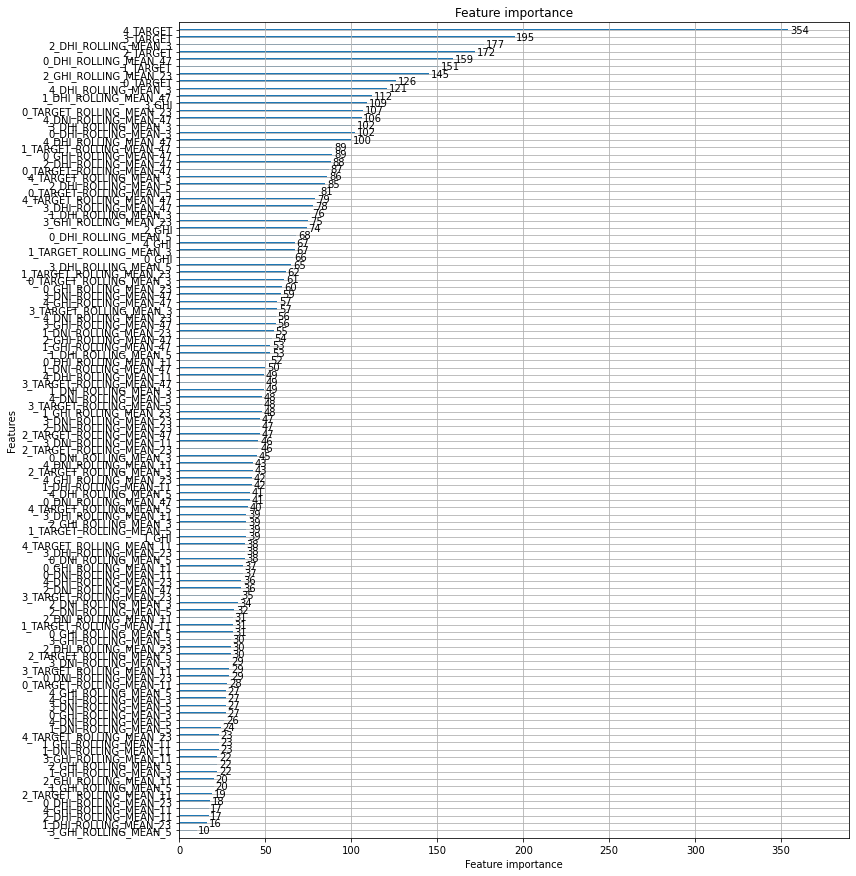

In [24]:
lgb.plot_importance(bst_2, figsize=(12, 15))

In [25]:
# submission_df.to_csv('lightgbm_dart_scale_rh_2021_01_12.csv', index=False)

In [26]:
submission_df[:48]

,id,q_0.1,q_0.2,q_0.3,q_0.4,q_0.5,q_0.6,q_0.7,q_0.8,q_0.9
0,0.csv_Day7_0h00m,0.000000,0.000000,0.000000,0.000000,0.000041,0.000165,0.000068,0.000193,0.000034
1,0.csv_Day7_0h30m,0.000000,0.000000,0.000000,0.000000,0.000041,0.000165,0.000068,0.000193,0.000034
2,0.csv_Day7_1h00m,0.000000,0.000000,0.000000,0.000000,0.000041,0.000165,0.000068,0.000193,0.000034
3,0.csv_Day7_1h30m,0.000000,0.000000,0.000000,0.000000,0.000041,0.000165,0.000068,0.000193,0.000034
4,0.csv_Day7_2h00m,0.000000,0.000000,0.000000,0.000000,0.000041,0.000165,0.000068,0.000193,0.000034
5,0.csv_Day7_2h30m,0.000000,0.000000,0.000000,0.000000,0.000041,0.000165,0.000068,0.000193,0.000034
6,0.csv_Day7_3h00m,0.000000,0.000000,0.000000,0.000000,0.000041,0.000165,0.000068,0.000193,0.000034
7,0.csv_Day7_3h30m,0.000000,0.000000,0.000000,0.000000,0.000041,0.000165,0.000068,0.000193,0.000034
8,0.csv_Day7_4h00m,0.000000,0.000000,0.000000,0.000000,0.000041,0.000165,0.000068,0.000193,0.000034
9,0.csv_Day7_4h30m,0.000000,0.000000,0.000000,0.000000,0.000041,0.000165,0.000068,0.000193,0.000034


In [27]:
for i in range(1, 10):
    q = i/10
    submission_df[f"q_{q}"][submission_df[f"q_{q}"] < 0] = 0

C:\Users\bees1\anaconda3\envs\dacon\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\bees1\anaconda3\envs\dacon\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\bees1\anaconda3\envs\dacon\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https:/

In [28]:
# prev_df = pd.read_csv('data/submission_history/2D_cnn_mean_shift_zero.csv')
# prev_df.head(5)

In [29]:
for i in range(1, 10):
    q = i/10
    submission_df[f"q_{q}"] = (submission_df[f"q_{q}"] + prev_df[f"q_{q}"]) / 2

submission_df[:48]

NameError: name 'prev_df' is not defined

In [ ]:
# submission_df.to_csv('2D_cnn_mean_shift_zero_n_lightgbm_dart_days_01_12.csv', index=False)